In [ ]:
import argparse
import os
import sys
import yaml
from shutil import copyfile
from datetime import datetime
import cv2
import torch
import torch.nn as nn
from torchvision import transforms
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter
from visualize_IG import *
from utils_IG import *
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from smooth_grad.gradients import VanillaGrad, SmoothGrad, GuidedBackpropGrad, GuidedBackpropSmoothGrad
from smooth_grad.image_utils import preprocess_image, save_as_gray_image
from smooth_grad.labels import IMAGENET_LABELS
import timm
# from GuideBP import Guided_backprop

In [ ]:
sys.path.insert(1, os.path.join(sys.path[0], '../'))
from project.cartoonX import CartoonX 
from project.pixelRDE import PixelRDE
from utils_IG import calculate_outputs_and_gradients, generate_entrie_images
from project.Integrated_grad import random_baseline_integrated_gradients

In [ ]:
LABEL_LIST = tuple(open(os.path.join(sys.path[0], "imagenet_labels.txt")).read().split('\n'))
LABEL_LIST = [x.replace('{',"").replace('\'',"").replace(',',"").replace('-'," ").replace('_'," ") for x in LABEL_LIST]

In [ ]:
files = os.listdir('random_images/')
imgdir='random_images'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Uncomment the model You want to use

In [ ]:
# Get classifier to explain
model = models.mobilenet_v3_small(pretrained=True).eval().to(device)
file_name = 'cartoon.npy'

# model = models.resnet18(pretrained=True).eval().to(device)
# file_name = 'cartoon_resnet18.npy'

# model = models.resnet50(pretrained=True).eval().to(device)
# file_name = 'cartoon_resnet50.npy'

# model = timm.create_model('vit_base_patch16_224', pretrained=True).eval().to(device)
# file_name = 'cartoon_vitb16.npy'

In [ ]:
with open(os.path.join(sys.path[0], "hparams.yaml")) as f:
    HPARAMS_CARTOONX = yaml.load(f, Loader=yaml.FullLoader)["CartoonX"]

with open(os.path.join(sys.path[0], "hparams.yaml")) as f:
    HPARAMS_PIXEL_RDE = yaml.load(f, Loader=yaml.FullLoader)["PixelRDE"]

# Initialize wavelet RDE and pixel RDE
cartoonX = CartoonX(model=model, device=device, **HPARAMS_CARTOONX)
pixelRDE = PixelRDE(model=model, device=device, **HPARAMS_PIXEL_RDE)


In [ ]:
def k_largest_index_argsort(a, k):
    idx = np.argsort(a.ravel())[:-k-1:-1]
    return np.column_stack(np.unravel_index(idx, a.shape))

def createmaskedimage(img,grad,percent,noise):
    #grad:L X B
    num_pixels=int(grad.shape[0]*grad.shape[1]*percent)
    mask=np.zeros((grad.shape[0],grad.shape[1]))
    topk_idx=k_largest_index_argsort(grad,num_pixels)
    mask[topk_idx[:,0],topk_idx[:,1]]=1
    mask=torch.tensor(mask).unsqueeze(0).unsqueeze(0).to(device)#1 X 1 X L X B
    noise=torch.randn(img.shape)
    new_img=img*mask+torch.clip(noise.to(device)*(1-mask),0,1)
    return(mask,new_img)

def save_as_gray_image(img, filename, percentile=99):#smoothgrad
    img_2d = np.sum(img, axis=0)
    span = abs(np.percentile(img_2d, percentile))
    vmin = -span
    vmax = span
    img_2d = np.clip((img_2d - vmin) / (vmax - vmin), -1, 1)
    cv2.imwrite(filename, img_2d * 255)

In [ ]:
# percent_list=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
percent_list=list(np.array(list(range(0,101)))/100)
full_array=torch.zeros((len(files),len(percent_list)))
full_array_smooth=torch.zeros((len(files),len(percent_list)))
full_array_cartoon=torch.zeros((len(files),len(percent_list)))
full_array_randomwavelet=torch.zeros((len(files),len(percent_list)))

In [ ]:
def marker(mask,percent):
    if percent==0:
        return 99999999
    elif percent==1:
        return -9999999
    mask_open=[mask[0].reshape(-1)]
    for i in range(len(mask[1])):
        mask_open.append(mask[1][i].reshape(-1))
    final_mask_open=torch.cat(mask_open,0).detach().cpu().numpy()
    final_mask_open=final_mask_open.reshape(-1,1) # 60000 X 1
    noise_symmet=torch.randn(final_mask_open.shape).numpy()*0.000000001
    topk_idx=k_largest_index_argsort(noise_symmet+final_mask_open,int(final_mask_open.shape[0]*percent))
    return(final_mask_open[topk_idx[-1][0],topk_idx[-1][1]])

def createmaskedwavelt(wavelet,grad_mask,mark):
    noise=(torch.randn(wavelet.shape).to(device)*(torch.std(wavelet)).to(device))+torch.mean(wavelet).to(device)
    new_wavelet=wavelet*(grad_mask>=mark)+noise.to(device)*((grad_mask<mark))
    return(mask,new_wavelet.float())



In [ ]:
# Cartoon
for i,fname in enumerate(files):
    print(f"Processing file: {fname}")
    x = Image.open(os.path.join(imgdir, fname))
    x = transforms.ToTensor()(x)
    # x = transforms.Resize(size=(256,256))(x)
    x = transforms.Resize(size=(224,224))(x)
    x = x.to(device).unsqueeze(0)
    input_img=x.detach()
    # classifiy image
    output = model(x)
    pred = nn.Softmax(dim=1)(output).max(1)[1].item()

    # set CartoonX hyperparameters
    HPARAMS ={"wave": "db3", "mode": "zero", "J": 5,
              "l1lambda": 10, "step_size": 1e-3,
              "num_steps": 100,  "batch_size": 16,
              "distortion_measure": "label"} 

    # get Cartoon RDE 
    cartoonX = CartoonX(model=model, device=device,return_mask=True, **HPARAMS)
    explanation,mask = cartoonX(x, pred)
    
    with torch.no_grad():
        for j,percent in enumerate(percent_list):
            yl, yh = cartoonX.forward_dwt(x) 
            markz=marker(mask,percent)
            _,obf_yl = createmaskedwavelt(yl,mask[0],markz)
            obf_yh = []
            for count, y in enumerate(yh):
                obf_yh.append(createmaskedwavelt(yh[count],mask[1][count],markz)[1])
            z = cartoonX.inverse_dwt((obf_yl,obf_yh))
            masked_img = z.clamp(0,1) 
            full_array_cartoon[i,j]=((F.softmax(model(input_img))-F.softmax(model(masked_img.float())))**2).sum()
    

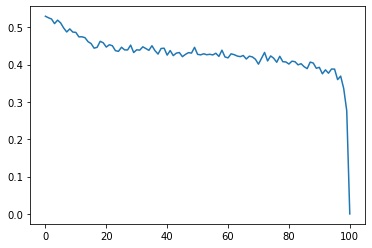

In [5]:
plt.plot(full_array_cartoon.mean(0))

In [ ]:
np.save(file_name, full_array_cartoon)

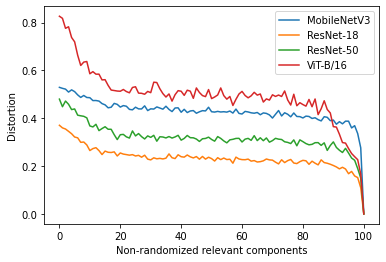

In [4]:
# Plot all figures
xxx=np.load('cartoon.npy')
plt.plot(xxx.mean(0), label='MobileNetV3')

xxx=np.load('cartoon_resnet18.npy')
plt.plot(xxx.mean(0), label='ResNet-18')

xxx=np.load('cartoon_resnet50.npy')
plt.plot(xxx.mean(0), label='ResNet-50')

xxx=np.load('cartoon_vitb16.npy')
plt.plot(xxx.mean(0), label='ViT-B/16')

plt.xlabel('Non-randomized relevant components')
plt.ylabel('Distortion')
plt.legend()
plt.savefig('archs.png')